In [95]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler

from sklearn.linear_model import LogisticRegression
# import geopandas as gpd
# import folium
# from folium import Choropleth, Circle, Marker
# from folium.plugins import HeatMap, MarkerCluster

## UFS UNILEVER

In [96]:
# data_UFS = pd.read_excel(r"C:\Users\bartd\Erasmus\Erasmus_\Jaar 4\Master Econometrie\Seminar\UnileverCase\Data\UFS_Universe_NL.xlsx")
data_UFS = pd.read_excel(r"C:\Users\bartd\Downloads\UFS_Universe_NLnew.xlsx")
data_UFS.describe()

,Latitude,Longitude,nrRatings,rating
count,43923.000000,43923.000000,22673.000000,22673.000000
mean,52.086075,5.233668,257.326644,4.234751
std,0.536001,0.871861,550.496204,0.391011
min,38.597626,-80.454903,1.000000,1.000000
25%,51.775885,4.652182,61.000000,4.100000
50%,52.088049,5.095511,142.000000,4.300000
75%,52.370192,5.839683,295.000000,4.500000
max,53.497267,8.506104,46991.000000,5.000000


In [97]:
data_UFS.columns

Index(['PlaceIDGoogle', 'operatorId', 'name', 'address', 'postalCode', 'city',
       'Latitude', 'Longitude', 'globalChannel', 'cuisineType', 'closed',
       'nrRatings', 'rating'],
      dtype='object')

In [98]:
data_UFS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45782 entries, 0 to 45781
Data columns (total 13 columns):
PlaceIDGoogle    27649 non-null object
operatorId       45782 non-null object
name             45782 non-null object
address          44004 non-null object
postalCode       44926 non-null object
city             44582 non-null object
Latitude         43923 non-null float64
Longitude        43923 non-null float64
globalChannel    45782 non-null object
cuisineType      45782 non-null object
closed           23062 non-null object
nrRatings        22673 non-null float64
rating           22673 non-null float64
dtypes: float64(4), object(9)
memory usage: 3.0+ MB


In [99]:
missing_data = pd.DataFrame({'total_missing': data_UFS.isnull().sum(), 'perc_missing': (data_UFS.isnull().sum()/len(data_UFS))*100})
missing_data

,total_missing,perc_missing
PlaceIDGoogle,18133,39.607269
operatorId,0,0.000000
name,0,0.000000
address,1778,3.883622
postalCode,856,1.869730
city,1200,2.621117
Latitude,1859,4.060548
Longitude,1859,4.060548
globalChannel,0,0.000000
cuisineType,0,0.000000


In [100]:
#Sure that we won't need this...
data_UFS.set_index('name', inplace= True)
data_UFS.drop(columns = ['operatorId'], inplace = True)

In [101]:
#Closed is categorical variable
data_UFS.closed = data_UFS.closed.astype('category')

In [102]:
#What kind of missing values are there?
for column in ['globalChannel', 'cuisineType', 'closed']:
    print(data_UFS.loc[:, column].unique())
    
#For globalChannel we might say that other restaurant is unknown
#For cuisineType Unkown is the missing value
#For closed nan is the missing value
# data = data.replace(['Unknown', 'Other Restaurant' ], np.nan)

['Bar' 'Other Restaurant' 'Cafe' 'Bistro' 'Steakhouse' 'Snackbar'
 'Pizzeria' 'Fast food restaurant' 'Sushi restaurant' 'Wine Bar'
 'Pannenkoekenhuis' 'Strandtent' 'Burger restaurant'
 'Food delivery restaurant' 'Highway restaurant']
['unknown' 'grill' 'local' 'pizza' 'african' 'asian' 'north american'
 'european' 'pasta' 'sushi' 'burger' 'fish and seafood'
 'doner, kebab or shawarma' 'pastry' 'vegan' 'tapas' 'middle eastern'
 'latin american']
[NaN, OPERATIONAL, CLOSED_PERMANENTLY, CLOSED_TEMPORARILY]
Categories (3, object): [OPERATIONAL, CLOSED_PERMANENTLY, CLOSED_TEMPORARILY]


In [103]:
#How much missing data is there?
missing_obs = data_UFS.isin([np.nan,'Unknown', 'Other Restaurant']).sum()
missing_data = pd.DataFrame({'total_missing':missing_obs, 'perc_missing': (missing_obs/len(data_UFS))*100})
missing_data


,total_missing,perc_missing
PlaceIDGoogle,18133,39.607269
address,1778,3.883622
postalCode,856,1.869730
city,1200,2.621117
Latitude,1859,4.060548
Longitude,1859,4.060548
globalChannel,26355,57.566292
cuisineType,0,0.000000
closed,22720,49.626491
nrRatings,23109,50.476170


In [104]:
data_UFS.describe()
data_UFS.shape

(45782, 11)

In [105]:
#Observations without dependent variable are copmletely useless
data_UFS = data_UFS[data_UFS['closed'].notna()]


In [106]:
#Shows restaurants that don't have postal code nor City adress
print(data_UFS.postalCode[data_UFS.postalCode.isna()])
print(data_UFS.city[data_UFS.city.isna()])

#without postal code we can't link it to the zipcode data
data_UFS = data_UFS[data_UFS.postalCode.notna()]
# data_UFS = data_UFS[data_UFS.city.notna()]

name
Cafe De Wolthoorn           NaN
Sultanim Döner              NaN
CAFE H. HEUTINCK            NaN
Metro Döner                 NaN
CHINA - GARDEN              NaN
AVRAM                       NaN
Restaurant Robuust          NaN
Eetcafé 't Brand eethoes    NaN
VOF Het Hapje               NaN
Name: postalCode, dtype: object
name
Restaurant Populair                      NaN
Restaurant Feestzaal In den Wijngaard    NaN
Restaurant Auberge Navet                 NaN
Columbus automatisering                  NaN
Café de Pub                              NaN
GaiaZoo Kerkrade                         NaN
Friterie Par Hasard                      NaN
nationaal militair museum                NaN
Name: city, dtype: object


In [107]:
#Recategorize global channel and onehotencode it
print(data_UFS.loc[:, 'globalChannel'].value_counts())
print(data_UFS.loc[:, 'cuisineType'].value_counts())
print(data_UFS.groupby('closed').cuisineType.value_counts())

Other Restaurant            16249
Cafe                         4346
Bar                           984
Fast food restaurant          626
Pizzeria                      325
Sushi restaurant              200
Burger restaurant             174
Food delivery restaurant      131
Bistro                         13
Pannenkoekenhuis                4
Steakhouse                      1
Name: globalChannel, dtype: int64
unknown                     15887
pasta                        1525
burger                       1227
pastry                        768
north american                722
asian                         675
pizza                         635
fish and seafood              457
sushi                         313
tapas                         219
european                      199
vegan                         155
local                         131
doner, kebab or shawarma       68
middle eastern                 51
african                        12
grill                           5
latin american

In [108]:
data_UFS.loc[data_UFS.globalChannel=='Burger restaurant',:]

,PlaceIDGoogle,address,postalCode,city,Latitude,Longitude,globalChannel,cuisineType,closed,nrRatings,rating
name,,,,,,,,,,,
Burgermeester | de Pijp,ChIJ12_uXvIJxkcRoGICDviN0R8,"Albert Cuypstraat 48, 1072 CV Amsterdam, Nethe...",1072 CV,Amsterdam,52.354601,4.888882,Burger restaurant,burger,CLOSED_PERMANENTLY,329.0,4.3
Monopoly Burger,ChIJ2UG38wrixUcR8768Zbwvw88,"Kinkerstraat 234 H, 1053 EN Amsterdam, Netherl...",1053 EN,Amsterdam,52.365702,4.865828,Burger restaurant,burger,OPERATIONAL,110.0,4.3
Twins Burgergrill,ChIJ32wp_THBwEcRisaUnX6dw88,"Aan de Drie Heren 4, 6191 BH Beek, Netherlands",6191 BH,Beek,50.946908,5.785987,Burger restaurant,burger,OPERATIONAL,26.0,3.5
Famous Burger,ChIJC53sU8YJxkcRgv20HDVqeak,"Nieuwezijds Voorburgwal 87, 1012 RE Amsterdam,...",1012 RE,Amsterdam,52.375185,4.892401,Burger restaurant,burger,OPERATIONAL,187.0,3.5
Burger Mode,ChIJFZ9fxNrWxUcRbMtS-W6_9pI,"7008 Miereakker,",2811BB,Reeuwijk,52.045744,4.725659,Burger restaurant,burger,OPERATIONAL,15.0,4.3
...,...,...,...,...,...,...,...,...,...,...,...
Burger Bitch,ChIJB3GsEZcLxkcR0P_CkdEOrhk,Arena boulevard,1101DL,Amsterdam,52.313199,4.942433,Burger restaurant,burger,OPERATIONAL,1773.0,3.9
Rimburgerhoeve,ChIJ6ylCLSOjwEcRP2zO_N9Lf-4,Rimburgerweg,6374LG,Landgraaf,50.906736,6.070765,Burger restaurant,burger,OPERATIONAL,31.0,4.2
Burgers Enzo,ChIJ1XXTBEtLx0cRyXjMGnP7Dfw,Markt,6041EM,Roermond,51.196178,5.985199,Burger restaurant,burger,OPERATIONAL,469.0,4.3


In [109]:
#Make categories
no_dining = ['Retail Bakery', 'Cafe', 'Bar', 'Wine Bar']
fastfood = ['Food delivery restaurant', 'Fast food restaurant']
dining = ['Bistro', 'Sushi restaurant', 'Pannenkoekenhuis', 'Steakhouse', 'Burger restaurant']
other = ['Other Restaurant', 'Bistro', 'Sushi restaurant', 'Pannenkoekenhuis', 'Steakhouse', 'Burger restaurant'] 
other = ['Other Restaurant'] 

In [110]:
#Create new variable with new categories
data_UFS.loc[data_UFS.globalChannel.isin(no_dining),'globalChannelShort'] = 'no_dining'
data_UFS.loc[data_UFS.globalChannel.isin(fastfood),'globalChannelShort'] ='fastfood'
data_UFS.loc[data_UFS.globalChannel.isin(dining), 'globalChannelShort'] = 'dining'
data_UFS.loc[data_UFS.globalChannel.isin(other),'globalChannelShort'] = 'other'
#TODO creeer vierde categorie

In [111]:
print(data_UFS.globalChannelShort.value_counts())
print(data_UFS.globalChannel.value_counts())

other        16249
no_dining     5330
fastfood       757
dining         392
Name: globalChannelShort, dtype: int64
Other Restaurant            16249
Cafe                         4346
Bar                           984
Fast food restaurant          626
Pizzeria                      325
Sushi restaurant              200
Burger restaurant             174
Food delivery restaurant      131
Bistro                         13
Pannenkoekenhuis                4
Steakhouse                      1
Name: globalChannel, dtype: int64


In [112]:
data_UFS['pc4'] = data_UFS.postalCode.str.extract('(\d+)').astype(int) #obtain postcode column 

#Check if every postcode is four elements
# [len(zipcode) for zipcode in data.pc4]
for index, zipcode in data_UFS.pc4.items():
    try:
        if len(str(zipcode))!= 4:
            print(zipcode)
            print(data_UFS.loc[index, :])
    except:
        print(zipcode)

0
PlaceIDGoogle            ChIJOUH-sl0zxEcR6wvzMQ8POJw
address               0000 ZZ Rotterdam, Netherlands
postalCode                                   0000 ZZ
city                                       Rotterdam
Latitude                                     51.8821
Longitude                                    4.54989
globalChannel                       Other Restaurant
cuisineType                                  unknown
closed                            CLOSED_PERMANENTLY
nrRatings                                         11
rating                                           4.5
globalChannelShort                             other
pc4                                                0
Name: Dushi \'Bon Dia\' Caribische eetgelegenheid, dtype: object


In [113]:
print(data_UFS.rating.isna().groupby(by = data_UFS.closed).sum())
print(data_UFS.nrRatings.isna().groupby(by = data_UFS.closed).sum())
# data_UFS.groupby(by=data_UFS.globalChannelShort).rating.agg(['mean', 'std'])
print(data_UFS.groupby(by=data_UFS.closed).rating.agg(['mean', 'std']))
print(data_UFS.groupby(by=data_UFS.closed).nrRatings.agg(['mean', 'std']))
# data_UFS.rating.isna().sum()
# data_UFS = data_UFS[data_UFS.rating.notna()]
# sns.violinplot(x = "rating", data = data_UFS)
data_UFS

closed
CLOSED_PERMANENTLY    265.0
CLOSED_TEMPORARILY      0.0
OPERATIONAL           130.0
Name: rating, dtype: float64
closed
CLOSED_PERMANENTLY    265.0
CLOSED_TEMPORARILY      0.0
OPERATIONAL           130.0
Name: nrRatings, dtype: float64
                        mean       std
closed                                
CLOSED_PERMANENTLY  4.085147  0.578640
CLOSED_TEMPORARILY  4.178070  0.305099
OPERATIONAL         4.263829  0.337400
                          mean         std
closed                                    
CLOSED_PERMANENTLY   75.822657  121.832792
CLOSED_TEMPORARILY  690.149123  905.419485
OPERATIONAL         286.557836  585.103162


,PlaceIDGoogle,address,postalCode,city,Latitude,Longitude,globalChannel,cuisineType,closed,nrRatings,rating,globalChannelShort,pc4
name,,,,,,,,,,,,,
Cote D'Azur,ChIJ-02QRaWgxEcRiwiNB3fA0Q8,"4524 cw 29, Kapellestraat, 4524 CW Sluis, Neth...",4524 CW,Sluis,51.307963,3.387080,Other Restaurant,unknown,OPERATIONAL,503.0,4.1,other,4524
PastaBar Undici,ChIJ-1miH-_vxkcRfUcpmNeqnfA,"De Driesprong 11, 5241 TJ Rosmalen, Netherlands",5241 TJ,Rosmalen,51.717089,5.363165,Other Restaurant,pasta,OPERATIONAL,40.0,4.0,other,5241
Hangar 85,ChIJ-1z3pV0zxEcRWuu8MzIpX0c,"Wijnhaven 85, 3011 WK Rotterdam, Netherlands",3011 WK,Rotterdam,51.917615,4.486134,Other Restaurant,unknown,CLOSED_PERMANENTLY,30.0,4.3,other,3011
Café \'Het Bruine Paard\',ChIJ-35RhM8JxkcRNK056NuK8Vo,"Prinsengracht 44, 1015 DW Amsterdam, Netherlands",1015 DW,Amsterdam,52.378234,4.885923,Cafe,unknown,OPERATIONAL,107.0,4.1,no_dining,1015
Hapjes & Sapjes,ChIJ-4U3i4Atx0cR6W5-s7XQszM,"Nieuwe Markt 4, 6001 EL Weert, Netherlands",6001 EL,Weert,51.253028,5.705612,Other Restaurant,unknown,OPERATIONAL,68.0,4.3,other,6001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Taj Mahal,ChIJvaf0I1tvxkcRDm5i65xuA24,Zadelstraat,3511LV,Utrecht,52.089882,5.118866,Other Restaurant,unknown,OPERATIONAL,601.0,4.0,other,3511
Rabarber,ChIJaRdsJ1tvxkcRiVN5UQdTkKE,Zadelstraat,3511LV,Utrecht,52.090008,5.119304,Other Restaurant,unknown,OPERATIONAL,271.0,4.5,other,3511
IJsDomein,ChIJryzLzVpvxkcRVlpxgsg7gtI,Vismarkt,3511KS,Utrecht,52.090583,5.120544,Fast food restaurant,north american,OPERATIONAL,32.0,4.0,fastfood,3511


,PlaceIDGoogle,address,postalCode,city,Latitude,Longitude,globalChannel,cuisineType,closed,nrRatings,rating,globalChannelShort,pc4
name,,,,,,,,,,,,,
Designer Outlet Roermond,ChIJe9ZV90tLx0cR64O_FCWBs2M,"Stadsweide 2, 6041 TD Roermond, Netherlands",6041 TD,Roermond,51.199615,5.988306,Other Restaurant,unknown,OPERATIONAL,46991.0,4.3,other,6041
IKEA,ChIJo6I07vC1xUcRZA27z1-1Q1c,"Olof Palmestraat 1, 2616 LN Delft, Netherlands",2616 LN,Delft,52.012984,4.381515,Other Restaurant,unknown,OPERATIONAL,18605.0,4.2,other,2616
Foodhallen,ChIJtWMWEeAJxkcR7PV7zX9aRh0,Bellamyplein 51,1053AT,Amsterdam,52.367062,4.868076,Other Restaurant,unknown,OPERATIONAL,14432.0,4.5,other,1053
IKEA,ChIJu0Vo1JwLxkcRhzKUgdqok4E,"Hullenbergweg 2, 1101 BL Amsterdam, Netherlands",1101 BL,Amsterdam,52.302803,4.949825,Other Restaurant,unknown,OPERATIONAL,13467.0,4.1,other,1101
IKEA Duiven,ChIJ9wVCgcSjx0cRmljggBDlxwo,"Biograaf 2, 6921 EV Duiven, Netherlands",6921 EV,Duiven,51.966051,5.996302,Other Restaurant,unknown,OPERATIONAL,11665.0,4.2,other,6921
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eeterij Den Dijk,ChIJfSZ9u0CNxkcRFjOqvrfwApc,Maasdijk,5317KS,Nederhemert,51.759614,5.158885,Other Restaurant,unknown,CLOSED_PERMANENTLY,NaN,NaN,other,5317
Mazenburg,ChIJdT8e8x4Tx0cRy3QLGUrHZ1c,Boxmeerseweg,6598MX,Heijen,51.655331,5.969943,Other Restaurant,unknown,OPERATIONAL,NaN,NaN,other,6598
Dilek's Food & Drinks,ChIJlyDCGDMBxkcR664K9_py1BY,Doctor J.M. den Uyllaan,1442VR,Purmerend,52.511286,4.966952,Other Restaurant,unknown,OPERATIONAL,NaN,NaN,other,1442


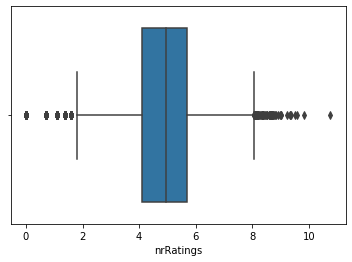

In [114]:
#Data exploration for nr of ratings
# sns.violinplot(x= data_UFS.nrRatings)
data_UFS.describe()
# plt.hist(data_UFS.nrRatings, bins=10000)
np.sum(data_UFS.nrRatings >10000)
sns.boxplot(np.log(data_UFS.nrRatings))
data_UFS.sort_values(by = "nrRatings", ascending=False)



In [115]:
#Normalize nr of ratings
data_UFS['log_nrRatings'] = np.log(data_UFS.nrRatings)
print(data_UFS.groupby(by=data_UFS.closed).log_nrRatings.agg(['mean', 'std']))
# data_UFS.loc[:, 'nrRatings'] = (data_UFS.nrRatings - data_UFS.nrRatings.min()) / (data_UFS.nrRatings.max() - data_UFS.nrRatings.min())

                        mean       std
closed                                
CLOSED_PERMANENTLY  3.400943  1.527151
CLOSED_TEMPORARILY  5.837361  1.339594
OPERATIONAL         5.027150  1.203198


In [116]:
data_UFS.groupby("closed").transform(lambda x: x.fillna(x.mean()))
data_UFS.groupby("closed").transform(lambda x: x.fillna(x.mean()))

,Latitude,Longitude,nrRatings,rating,pc4,log_nrRatings
name,,,,,,
Cote D'Azur,51.307963,3.387080,503.0,4.1,4524,6.220590
PastaBar Undici,51.717089,5.363165,40.0,4.0,5241,3.688879
Hangar 85,51.917615,4.486134,30.0,4.3,3011,3.401197
Café \'Het Bruine Paard\',52.378234,4.885923,107.0,4.1,1015,4.672829
Hapjes & Sapjes,51.253028,5.705612,68.0,4.3,6001,4.219508
...,...,...,...,...,...,...
Taj Mahal,52.089882,5.118866,601.0,4.0,3511,6.398595
Rabarber,52.090008,5.119304,271.0,4.5,3511,5.602119
IJsDomein,52.090583,5.120544,32.0,4.0,3511,3.465736


In [117]:
# df["value"] = df.groupby("name").transform(lambda x: x.fillna(x.mean()))
data_UFS.rating = data_UFS.groupby("closed").transform(lambda x:x.fillna(x.mean())).rating
data_UFS.log_nrRatings = data_UFS.groupby("closed").transform(lambda x:x.fillna(x.mean())).log_nrRatings
print(data_UFS.rating.isna().groupby(by = data_UFS.globalChannelShort).sum())

globalChannelShort
dining       False
fastfood     False
no_dining    False
other        False
Name: rating, dtype: bool


In [118]:
print(data_UFS.nrRatings.isna().groupby(by = data_UFS.globalChannelShort).sum())
data_UFS.groupby(by=data_UFS.globalChannelShort).nrRatings.agg(['mean', 'std'])
data_UFS.groupby(by=data_UFS.closed).nrRatings.agg(['mean', 'std'])
data_UFS.rating.describe()

globalChannelShort
dining         6.0
fastfood       8.0
no_dining    124.0
other        255.0
Name: nrRatings, dtype: float64


count    23053.000000
mean         4.233217
std          0.387801
min          1.000000
25%          4.100000
50%          4.300000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

In [119]:
#One hot encode
data_UFS.globalChannelShort = data_UFS.globalChannelShort.astype('category')
data_UFS = pd.get_dummies(data_UFS, columns = ['globalChannelShort'], prefix = ['globalChannel'])

data_UFS.head()

,PlaceIDGoogle,address,postalCode,city,Latitude,Longitude,globalChannel,cuisineType,closed,nrRatings,rating,pc4,log_nrRatings,globalChannel_dining,globalChannel_fastfood,globalChannel_no_dining,globalChannel_other
name,,,,,,,,,,,,,,,,,
Cote D'Azur,ChIJ-02QRaWgxEcRiwiNB3fA0Q8,"4524 cw 29, Kapellestraat, 4524 CW Sluis, Neth...",4524 CW,Sluis,51.307963,3.387080,Other Restaurant,unknown,OPERATIONAL,503.0,4.1,4524,6.220590,0,0,0,1
PastaBar Undici,ChIJ-1miH-_vxkcRfUcpmNeqnfA,"De Driesprong 11, 5241 TJ Rosmalen, Netherlands",5241 TJ,Rosmalen,51.717089,5.363165,Other Restaurant,pasta,OPERATIONAL,40.0,4.0,5241,3.688879,0,0,0,1
Hangar 85,ChIJ-1z3pV0zxEcRWuu8MzIpX0c,"Wijnhaven 85, 3011 WK Rotterdam, Netherlands",3011 WK,Rotterdam,51.917615,4.486134,Other Restaurant,unknown,CLOSED_PERMANENTLY,30.0,4.3,3011,3.401197,0,0,0,1
Café \'Het Bruine Paard\',ChIJ-35RhM8JxkcRNK056NuK8Vo,"Prinsengracht 44, 1015 DW Amsterdam, Netherlands",1015 DW,Amsterdam,52.378234,4.885923,Cafe,unknown,OPERATIONAL,107.0,4.1,1015,4.672829,0,0,1,0
Hapjes & Sapjes,ChIJ-4U3i4Atx0cR6W5-s7XQszM,"Nieuwe Markt 4, 6001 EL Weert, Netherlands",6001 EL,Weert,51.253028,5.705612,Other Restaurant,unknown,OPERATIONAL,68.0,4.3,6001,4.219508,0,0,0,1


## ZIPCODE



In [120]:
data_zip_old = pd.read_excel(r"C:\Users\bartd\Erasmus\Erasmus_\Jaar 4\Master Econometrie\Seminar\UnileverCase\Data\Neighbourhood_Descriptives.xlsx")
data_zip = pd.read_csv(r"C:\Users\bartd\Erasmus\Erasmus_\Jaar 4\Master Econometrie\Seminar\UnileverCase_Conda\Data\preprocessedData\zipcodedata_KNN_normalized_version_10.csv")
data_zip.head()

,pc4,AANTAL_HH,P_MAN,P_VROUW,P_INW_014,P_INW_1524,P_INW_2544,P_INW_4564,AFS_TREINS,AFS_TRNOVS,...,AV5_FOOD,OAD,P_NL_ACHTG,P_WE_MIG_A,P_NW_MIG_A,GEM_HH_GR,P_UITKMINAOW,P_LINK_HH,P_HINK_HH,log_median_inc
0,1011.0,0.476385,0.469596,0.530404,0.164510,0.122049,0.411441,0.586260,0.013746,0.011345,...,0.970694,0.604363,0.555556,0.500000,0.250,0.166667,0.137837,0.553216,0.253752,0.571038
1,1012.0,0.441056,0.596621,0.403379,0.086033,0.165778,0.699242,0.357429,0.006873,0.004862,...,0.982171,0.731019,0.444444,0.666667,0.250,0.125000,0.083131,0.622222,0.193724,0.532966
2,1013.0,0.937151,0.384131,0.615869,0.286184,0.074933,0.452632,0.566274,0.022337,0.019449,...,0.867859,0.550948,0.444444,0.333333,0.250,0.250000,0.210013,0.592982,0.227831,0.566833
3,1014.0,0.063964,0.538300,0.461700,0.451113,0.035246,0.683987,0.370877,0.022337,0.019449,...,0.633379,0.249935,0.555556,0.333333,0.125,0.333333,0.146412,0.338012,0.398363,0.721324
4,1015.0,0.728152,0.433311,0.566689,0.185126,0.107467,0.439095,0.571807,0.015464,0.012966,...,0.975471,0.951866,0.555556,0.500000,0.125,0.166667,0.145534,0.563743,0.263302,0.571038


In [25]:
data_zip.columns

Index(['pc4', 'AANTAL_HH', 'P_MAN', 'P_VROUW', 'P_INW_014', 'P_INW_1524',
       'P_INW_2544', 'P_INW_4564', 'AFS_TREINS', 'AFS_TRNOVS', 'AFS_OPRIT',
       'P_INW_65PL', 'AV1_FOOD', 'AV3_FOOD', 'AV5_FOOD', 'OAD', 'P_NL_ACHTG',
       'P_WE_MIG_A', 'P_NW_MIG_A', 'GEM_HH_GR', 'P_UITKMINAOW', 'P_LINK_HH',
       'P_HINK_HH', 'log_median_inc'],
      dtype='object')

In [26]:
data_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4068 entries, 0 to 4067
Data columns (total 24 columns):
pc4               4068 non-null float64
AANTAL_HH         4068 non-null float64
P_MAN             4068 non-null float64
P_VROUW           4068 non-null float64
P_INW_014         4068 non-null float64
P_INW_1524        4068 non-null float64
P_INW_2544        4068 non-null float64
P_INW_4564        4068 non-null float64
AFS_TREINS        4068 non-null float64
AFS_TRNOVS        4068 non-null float64
AFS_OPRIT         4068 non-null float64
P_INW_65PL        4068 non-null float64
AV1_FOOD          4068 non-null float64
AV3_FOOD          4068 non-null float64
AV5_FOOD          4068 non-null float64
OAD               4068 non-null float64
P_NL_ACHTG        4068 non-null float64
P_WE_MIG_A        4068 non-null float64
P_NW_MIG_A        4068 non-null float64
GEM_HH_GR         4068 non-null float64
P_UITKMINAOW      4068 non-null float64
P_LINK_HH         4068 non-null float64
P_HINK_HH    

In [121]:
data_zip.pc4 = data_zip.pc4.astype('int32')
data_zip.set_index('pc4', drop = True, inplace= True)

In [122]:
missing_data_df = ((data_zip.isnull()) | (data_zip == -99997))
# missing_data = pd.DataFrame({'total_missing': data_zip.isnull().sum(), 'perc_missing': (data_zip.isnull().sum()/len(data_zip))*100})

missing_data = pd.DataFrame({'total_missing': missing_data_df.sum(), 'perc_missing': (missing_data_df.sum()/len(data_zip))*100})
missing_data

,total_missing,perc_missing
AANTAL_HH,0,0.0
P_MAN,0,0.0
P_VROUW,0,0.0
P_INW_014,0,0.0
P_INW_1524,0,0.0
P_INW_2544,0,0.0
P_INW_4564,0,0.0
AFS_TREINS,0,0.0
AFS_TRNOVS,0,0.0
AFS_OPRIT,0,0.0


In [123]:
labels = pd.read_csv(r"C:\Users\bartd\Erasmus\Erasmus_\Jaar 4\Master Econometrie\Seminar\UnileverCase_Conda\Data\preprocessedData\pc4_best_labels_version_10_SOM_k-means.csv")
labels.set_index('pc4', drop=True,inplace=True)


In [124]:
data_zip_X =  pd.concat([data_zip, labels], axis=1)


In [125]:
y = data_UFS.closed
X = data_UFS.loc[:, ['globalChannel_fastfood', 'globalChannel_no_dining', 'globalChannel_dining', 'log_nrRatings', 'rating', 'pc4']]
W = data_zip_X

In [126]:
print('y size: ', y.shape)
print('x size: ', X.shape)
print('W size: ', W.shape)

y size:  (23053,)
x size:  (23053, 6)
W size:  (4068, 24)


In [127]:
#1 = operational, 2=closed_perm, 3 = closed temp
X['dv'] = pd.factorize(y)[0]+1
WX = W.merge(X, left_index = True, right_on='pc4')

y = WX['dv']
WX = WX.drop('dv', axis = 1)

In [86]:
WX.shape

(23042, 30)

In [87]:
y.value_counts()

1    18976
2     3838
3      228
Name: dv, dtype: int64

In [128]:
WX[["labels", "globalChannel_fastfood", "globalChannel_dining", 'globalChannel_no_dining']] = WX[["labels", "globalChannel_fastfood", "globalChannel_dining", 'globalChannel_no_dining']].astype('category')
WX.drop(["P_INW_014", "P_NL_ACHTG", "P_LINK_HH"], axis = 1, inplace=True)
WX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23042 entries, Vijaya Restaurant to Herberg In De Valk
Data columns (total 27 columns):
AANTAL_HH                  23042 non-null float64
P_MAN                      23042 non-null float64
P_VROUW                    23042 non-null float64
P_INW_1524                 23042 non-null float64
P_INW_2544                 23042 non-null float64
P_INW_4564                 23042 non-null float64
AFS_TREINS                 23042 non-null float64
AFS_TRNOVS                 23042 non-null float64
AFS_OPRIT                  23042 non-null float64
P_INW_65PL                 23042 non-null float64
AV1_FOOD                   23042 non-null float64
AV3_FOOD                   23042 non-null float64
AV5_FOOD                   23042 non-null float64
OAD                        23042 non-null float64
P_WE_MIG_A                 23042 non-null float64
P_NW_MIG_A                 23042 non-null float64
GEM_HH_GR                  23042 non-null float64
P_UITKMINAOW     

In [129]:
WX_train, WX_test, y_train, y_test = train_test_split(WX, y, test_size=0.33, random_state=42)

In [130]:
y_train.to_csv(r"./Data/preprocessedData/y_train.csv")
WX_train.to_csv(r"./Data/preprocessedData/WX_train.csv")
y_test.to_csv(r"./Data/preprocessedData/y_test.csv")
WX_test.to_csv(r"./Data/preprocessedData/WX_test.csv")

C:\Users\bartd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
C:\Users\bartd\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## RESAMPLING

In [131]:
#SMOTE NC
cols = WX.columns
num_cols = WX._get_numeric_data().columns
cat_col = list(set(cols) - set(num_cols))
cat_col_idx = [WX.columns.get_loc(c) for c in cat_col if c in WX]

smote_nc = SMOTENC(categorical_features =cat_col_idx, random_state = 0)
WX_train_resampled, y_train_resampled = smote_nc.fit_resample(WX_train, y_train)

In [132]:
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_train_resampled).items()))

[(1, 12733), (2, 2551), (3, 154)]
[(1, 12733), (2, 12733), (3, 12733)]


In [133]:
#WX_train_resampled, WX_test, y_train_resampled, y_test 
y_train_resampled.to_csv(r"./Data/preprocessedData/y_tr_re.csv")
WX_train_resampled.to_csv(r"./Data/preprocessedData/WX_tr_re.csv")
y_test.to_csv(r"./Data/preprocessedData/y_test.csv")
WX_test.to_csv(r"./Data/preprocessedData/WX_test.csv")

C:\Users\bartd\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
C:\Users\bartd\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


## Logistic regression

In [ ]:
WX_train.columns
col_interest = ["INWONER",'GEM_HH_GR','globalChannel_fastfood', 'globalChannel_other',
       'rating', 'median_inc']

In [ ]:
clf = LogisticRegression(random_state=0).fit(WX_train_resampled.loc[:,col_interest], y_train_resampled)
clf.score(WX_train_resampled.loc[:,col_interest], y_train_resampled)
#WX_train, WX_test, y_train, y_test